# Performing an adversarial attack on images

What if we want to modify
an image in such a way that the change in image is so minimal that it is
indistinguishable from the original image for a human, but still the neural network
model perceives the object as belonging to a different class? Adversarial attacks on
images come in handy in such a scenario.

Adversarial attacks refer to the changes that we make to input image values (pixels)
so that we meet a certain objective.

In this section, we will learn about modifying an image slightly in such a way that the
pre-trained models now predict them as a different class (specified by the user) and
not the original class. The strategy we will adopt is as follows:

1. Provide an image of an elephant.

2. Specify the target class corresponding to the image.

3. Import a pre-trained model where the parameters of the model are set so
that they are not updated ( gradients = False ).

4. Specify that we calculate gradients on input image pixel values and not on
the weight values of the network. This is because while training to fool a
network, we do not have control over the model, but have control only
over the image we send to the model.

5. Calculate the loss corresponding to the model predictions and the target
class.

6. Perform backpropagation on the model. This step helps us understand the
gradient associated with each input pixel value.

7. Update the input image pixel values based on the direction of the gradient
corresponding to each input pixel value.

8. Repeat steps 5, 6, and 7 over multiple epochs.


In [1]:
!pip install torch_snippets
from torch_snippets import inspect, show, np, torch, nn
from torchvision.models import resnet50
model = resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model = model.eval()
import requests
from PIL import Image
url = 'https://lionsvalley.co.za/wp-content/uploads/2015/11/african-elephant-square.jpg'
original_image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
original_image = np.array(original_image)
original_image = torch.Tensor(original_image)

/home/lacie/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lacie/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/lacie/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/lacie/.cache/torch/hub/checkpoints/resn

In [2]:
image_net_classes = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
image_net_classes = requests.get(image_net_classes).text
image_net_ids = eval(image_net_classes)
image_net_classes = {i:j for j,i in image_net_ids.items()}

In [ ]:
from torchvision import transforms as T
from torch.nn import functional as F
normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalize = T.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])
def image2tensor(input):
    x = normalize(input.clone().permute(2,0,1)/255.)[None]
    return x
def tensor2image(input):
    x = (denormalize(input[0].clone()).permute(1,2,0)*255.).type(torch.uint8)
    return x

In [ ]:
def predict_on_image(input):
    model.eval()
    show(input)
    input = image2tensor(input)
    pred = model(input)
    pred = F.softmax(pred, dim=-1)[0]
    prob, clss = torch.max(pred, 0)
    clss = image_net_ids[clss.item()]
    print(f'PREDICTION: `{clss}` @ {prob.item()}')

In [ ]:
from tqdm import trange
losses = []
def attack(image, model, target, epsilon=1e-6):
    input = image2tensor(image)
    input.requires_grad = True
    pred = model(input)
    loss = nn.CrossEntropyLoss()(pred, target)
    loss.backward()
    losses.append(loss.mean().item())
    output = input - epsilon * input.grad.sign()
    output = tensor2image(output)
    del input
    return output.detach()

In [ ]:
modified_images = []
desired_targets = ['lemon', 'comic book', 'sax, saxophone']

In [ ]:
for target in desired_targets:
    target = torch.tensor([image_net_classes[target]])
    image_to_attack = original_image.clone()
    for _ in trange(10):
        image_to_attack = attack(image_to_attack, model, target)
    modified_images.append(image_to_attack)


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


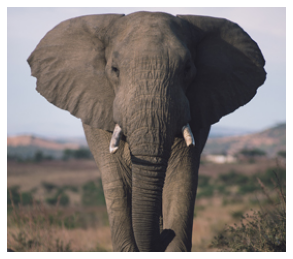

PREDICTION: `African elephant, Loxodonta africana` @ 0.5234400033950806
Tensor	Shape: torch.Size([237, 270, 3])	Min: 17.000	Max: 255.000	Mean: 110.237	dtype: torch.float32


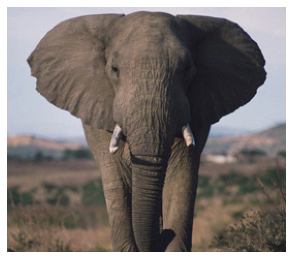

PREDICTION: `lemon` @ 0.9999923706054688
Tensor	Shape: torch.Size([237, 270, 3])	Min: 11.000	Max: 248.000	Mean: 105.229	dtype: torch.uint8


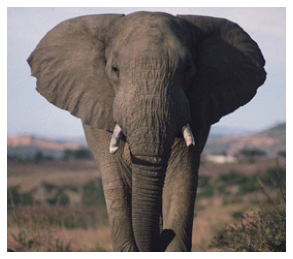

PREDICTION: `comic book` @ 0.9999936819076538
Tensor	Shape: torch.Size([237, 270, 3])	Min: 9.000	Max: 245.000	Mean: 105.236	dtype: torch.uint8


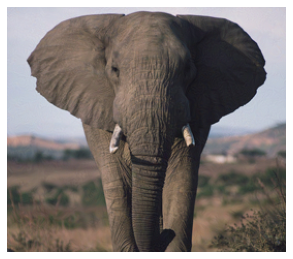

PREDICTION: `sax, saxophone` @ 0.9999990463256836
Tensor	Shape: torch.Size([237, 270, 3])	Min: 11.000	Max: 247.000	Mean: 105.237	dtype: torch.uint8


In [ ]:
for image in [original_image, *modified_images]:
    predict_on_image(image)
    inspect(image)